In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/ids datasets/ids_reduced_dataset2.csv')

In [ ]:
df.shape

(237092, 80)

In [ ]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,56927,6,21/02/2018 02:18:48,1426,5,2,935,266,935,0,187.000000,418.144712,266,0,133.0,188.090404,842215.988800,4908.835905,2.376667e+02,3.410986e+02,896,6,1426,3.565000e+02,5.372662e+02,1147,6,896,896.0,0.000000e+00,896,896,0,0,0,0,124,40,3506.311360,1402.524544,0,935,150.125000,330.514939,109240.125000,0,0,1,1,0,0,0,1,0,171.571429,187.000000,133.0,0,0,0,0,0,0,5,935,2,266,65535,32768,1,20,0.0,0.000000e+00,0,0,0.00,0.000000e+00,0,0,Benign
1,50052,6,28/02/2018 08:50:07,11,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,181818.181818,1.100000e+01,0.000000e+00,11,11,0,0.000000e+00,0.000000e+00,0,0,0,0.0,0.000000e+00,0,0,0,0,0,0,20,20,90909.090909,90909.090909,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,1,0.000000,0.000000,0.0,0,0,0,0,0,0,1,0,1,0,180,258,0,20,0.0,0.000000e+00,0,0,0.00,0.000000e+00,0,0,Benign
2,51377,6,21/02/2018 02:30:21,17820,5,2,935,316,935,0,187.000000,418.144712,316,0,158.0,223.445743,70202.020200,392.817060,2.970000e+03,6.994478e+03,17245,7,17820,4.455000e+03,8.749120e+03,17578,7,17245,17245.0,0.000000e+00,17245,17245,0,0,0,0,124,40,280.583614,112.233446,0,935,156.375000,333.478608,111207.982100,0,0,1,1,0,0,0,1,0,178.714286,187.000000,158.0,0,0,0,0,0,0,5,935,2,316,65535,32768,1,20,0.0,0.000000e+00,0,0,0.00,0.000000e+00,0,0,Benign
3,135,6,28/02/2018 03:48:55,139486,5,5,1170,338,816,0,234.000000,339.570317,306,0,67.6,133.988059,10811.120830,71.691783,1.549844e+04,3.047160e+04,69360,7,138964,3.474100e+04,4.001666e+04,69639,32,139462,34865.5,3.996235e+04,69548,32,0,0,0,0,108,108,35.845891,35.845891,0,816,137.090909,249.587441,62293.890910,0,0,0,1,0,0,0,0,1,150.800000,234.000000,67.6,0,0,0,0,0,0,5,1170,5,338,65535,63190,3,20,0.0,0.000000e+00,0,0,0.00,0.000000e+00,0,0,Benign
4,80,6,15/02/2018 11:12:17,106493993,15,3,2530,0,230,0,168.666667,105.279673,0,0,0.0,0.000000,23.757209,0.169024,6.264353e+06,1.339493e+07,53247628,3,106493990,7.606714e+06,1.448563e+07,53247628,386,105471072,52735536.0,3.073892e+07,74471235,30999837,0,0,0,0,496,100,0.140853,0.028171,0,230,133.157895,116.669173,13611.695906,0,0,0,1,0,0,0,0,0,140.555556,168.666667,0.0,0,0,0,0,0,0,15,2530,3,0,26883,0,11,32,6155658.5,2.153965e+06,7678742,4632575,23545668.25,2.067927e+07,53247628,6656061,DoS attacks-Slowloris


In [ ]:
df.Label.value_counts()

Benign                   200000
Infilteration             10000
DDOS attack-HOIC          10000
DoS attacks-GoldenEye     10000
DoS attacks-Slowloris      5000
DDOS attack-LOIC-UDP       1730
Brute Force -Web            249
Brute Force -XSS             79
SQL Injection                34
Name: Label, dtype: int64

Data preprocessing
step1 conversion of time stamps

In [ ]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['Timestamp'] = (df['Timestamp'] - df['Timestamp'].iloc[0])/pd.to_timedelta('1Min')

In [ ]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,56927,6,0.000000,1426,5,2,935,266,935,0,187.000000,418.144712,266,0,133.0,188.090404,842215.988800,4908.835905,2.376667e+02,3.410986e+02,896,6,1426,3.565000e+02,5.372662e+02,1147,6,896,896.0,0.000000e+00,896,896,0,0,0,0,124,40,3506.311360,1402.524544,0,935,150.125000,330.514939,109240.125000,0,0,1,1,0,0,0,1,0,171.571429,187.000000,133.0,0,0,0,0,0,0,5,935,2,266,65535,32768,1,20,0.0,0.000000e+00,0,0,0.00,0.000000e+00,0,0,Benign
1,50052,6,10471.316667,11,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0,0.000000,0.000000,181818.181818,1.100000e+01,0.000000e+00,11,11,0,0.000000e+00,0.000000e+00,0,0,0,0.0,0.000000e+00,0,0,0,0,0,0,20,20,90909.090909,90909.090909,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,1,0.000000,0.000000,0.0,0,0,0,0,0,0,1,0,1,0,180,258,0,20,0.0,0.000000e+00,0,0,0.00,0.000000e+00,0,0,Benign
2,51377,6,11.550000,17820,5,2,935,316,935,0,187.000000,418.144712,316,0,158.0,223.445743,70202.020200,392.817060,2.970000e+03,6.994478e+03,17245,7,17820,4.455000e+03,8.749120e+03,17578,7,17245,17245.0,0.000000e+00,17245,17245,0,0,0,0,124,40,280.583614,112.233446,0,935,156.375000,333.478608,111207.982100,0,0,1,1,0,0,0,1,0,178.714286,187.000000,158.0,0,0,0,0,0,0,5,935,2,316,65535,32768,1,20,0.0,0.000000e+00,0,0,0.00,0.000000e+00,0,0,Benign
3,135,6,10170.116667,139486,5,5,1170,338,816,0,234.000000,339.570317,306,0,67.6,133.988059,10811.120830,71.691783,1.549844e+04,3.047160e+04,69360,7,138964,3.474100e+04,4.001666e+04,69639,32,139462,34865.5,3.996235e+04,69548,32,0,0,0,0,108,108,35.845891,35.845891,0,816,137.090909,249.587441,62293.890910,0,0,0,1,0,0,0,0,1,150.800000,234.000000,67.6,0,0,0,0,0,0,5,1170,5,338,65535,63190,3,20,0.0,0.000000e+00,0,0,0.00,0.000000e+00,0,0,Benign
4,80,6,-8106.516667,106493993,15,3,2530,0,230,0,168.666667,105.279673,0,0,0.0,0.000000,23.757209,0.169024,6.264353e+06,1.339493e+07,53247628,3,106493990,7.606714e+06,1.448563e+07,53247628,386,105471072,52735536.0,3.073892e+07,74471235,30999837,0,0,0,0,496,100,0.140853,0.028171,0,230,133.157895,116.669173,13611.695906,0,0,0,1,0,0,0,0,0,140.555556,168.666667,0.0,0,0,0,0,0,0,15,2530,3,0,26883,0,11,32,6155658.5,2.153965e+06,7678742,4632575,23545668.25,2.067927e+07,53247628,6656061,DoS attacks-Slowloris


In [ ]:
null_counts = df.isnull().sum()
total_nulls = null_counts.sum() #checking for the null values
print(total_nulls)

953


In [ ]:
features = df.dtypes[df.dtypes != 'object'].index
df[features] = df[features].apply(lambda x: (x - x.mean()) / (x.std()))
# Fill empty values by 0
df = df.fillna(0)

In [ ]:
null_counts = df.isnull().sum()
total_nulls = null_counts.sum()
print(total_nulls)

0


In [ ]:
df.shape

(237092, 80)

In [ ]:
df.head()#results after standardising data

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1.292074,-0.494878,-0.683570,-0.350159,-0.083358,-0.019224,-0.082306,-0.013126,1.292133,-0.34361,1.179692,1.376314,-0.132583,-0.446057,0.049535,0.195829,0.0,0.0,-0.194661,-0.223409,-0.303391,-0.124021,-0.337569,-0.197410,-0.257770,-0.286390,-0.145133,-0.289627,-0.173773,-0.240560,-0.249236,-0.114924,-0.211319,0.0,-0.038285,0.0,-0.083195,-0.020748,-0.145349,-0.148978,-0.358315,0.805752,0.497300,0.879831,0.610560,-0.062209,-0.211319,1.143167,0.855495,-0.498243,-0.173455,-0.038285,1.143167,-0.549307,0.529462,1.179692,0.049535,0.0,0.0,0.0,0.0,0.0,0.0,-0.083358,-0.082306,-0.019224,-0.013126,1.377051,0.997566,-0.083403,0.241659,-0.092556,-0.066744,-0.097973,-0.077978,-0.270378,-0.134609,-0.280819,-0.254234,Benign
1,1.038445,-0.494878,0.941965,-0.350206,-0.083747,-0.027102,-0.085149,-0.014587,-0.953523,-0.34361,-1.093838,-0.895675,-0.749561,-0.446057,-0.846238,-0.802995,0.0,0.0,-0.194690,-0.223469,-0.303450,-0.124021,-0.337616,-0.197442,-0.257912,-0.286467,-0.145134,-0.289662,-0.173870,-0.240560,-0.249303,-0.115035,-0.211319,0.0,-0.038285,0.0,-0.084460,-0.028638,0.297519,0.927532,-0.358315,-1.037707,-1.037687,-1.033988,-0.792761,-0.062209,-0.211319,-0.874759,-1.168909,2.007046,5.765151,-0.038285,-0.874759,0.827223,-1.128865,-1.093838,-0.846238,0.0,0.0,0.0,0.0,0.0,0.0,-0.083747,-0.085149,-0.027102,-0.014587,-0.868740,-0.719272,-0.083500,0.241659,-0.092556,-0.066744,-0.097973,-0.077978,-0.270378,-0.134609,-0.280819,-0.254234,Benign
2,1.087326,-0.494878,-0.681777,-0.349621,-0.083358,-0.019224,-0.082306,-0.012852,1.292133,-0.34361,1.179692,1.376314,-0.016610,-0.446057,0.217914,0.383578,0.0,0.0,-0.194314,-0.222242,-0.302297,-0.124021,-0.337030,-0.197034,-0.255605,-0.285284,-0.145133,-0.288996,-0.171996,-0.240560,-0.248012,-0.112911,-0.211319,0.0,-0.038285,0.0,-0.083195,-0.020748,-0.161694,-0.164497,-0.358315,0.805752,0.561204,0.896992,0.635839,-0.062209,-0.211319,1.143167,0.855495,-0.498243,-0.173455,-0.038285,1.143167,-0.549307,0.598502,1.179692,0.217914,0.0,0.0,0.0,0.0,0.0,0.0,-0.083358,-0.082306,-0.019224,-0.012852,1.377051,0.997566,-0.083403,0.241659,-0.092556,-0.066744,-0.097973,-0.077978,-0.270378,-0.134609,-0.280819,-0.254234,Benign
3,-0.803064,-0.494878,0.895208,-0.345624,-0.083358,0.004411,-0.081591,-0.012731,1.006322,-0.34361,1.751113,0.949380,-0.039804,-0.446057,-0.390943,-0.091473,0.0,0.0,-0.192721,-0.218124,-0.298809,-0.124021,-0.333046,-0.194255,-0.247362,-0.281778,-0.145131,-0.284278,-0.170081,-0.231185,-0.244096,-0.115031,-0.211319,0.0,-0.038285,0.0,-0.083390,0.006077,-0.162934,-0.165416,-0.358315,0.571130,0.364030,0.411227,0.007479,-0.062209,-0.211319,-0.874759,0.855495,-0.498243,-0.173455,-0.038285,-0.874759,0.827223,0.328696,1.751113,-0.390943,0.0,0.0,0.0,0.0,0.0,0.0,-0.083358,-0.081591,0.004411,-0.012731,1.377051,2.604137,-0.083208,0.241659,-0.092556,-0.066744,-0.097973,-0.077978,-0.270378,-0.134609,-0.280819,-0.254234,Benign
4,-0.805093,-0.494878,-1.

In [ ]:
pd.options.display.max_columns = None
df.describe()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,237092.0,237092.0,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,237092.0,2.370920e+05,237092.0,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,237092.0,237092.0,237092.0,237092.0,237092.0,237092.0,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05,2.370920e+05
mean,1.360596e-17,-3.812066e-17,4.273590e-17,1.056410e-17,3.116784e-18,2.022912e-18,2.037897e-18,7.492268e-19,-8.031711e-18,-4.315546e-17,-1.484068e-16,3.536351e-17,3.587298e-17,3.092808e-17,1.203708e-16,3.599286e-17,0.0,0.0,-4.519336e-17,-1.288670e-18,-2.130801e-17,2.577340e-18,-1.306652e-17,9.350351e-18,6.182620e-17,4.041329e-17,8.750969e-18,2.279148e-17,-1.383073e-17,-6.144409e-17,-1.156806e-17,1.416039e-17,7.570188e-17,0.0,2.616300e-17,0.0,-4.075794e-18,-2.697217e-18,4.075794e-18,2.205724e-17,-4.807039e-17,7.159611e-17,1.110654e-16,-1.966720e-16,-5.397430e-17,1.888052e-17,7.570188e-17,3.596289e-19,7.342423e-18,-1.171791e-16,-6.856924e-17,2.616300e-17,3.596289e-19,-4.837008e-17,1.001267e-16,-1.484068e-16,1.232478e-16,0.0,0.0,0.0,0.0,0.0,0.0,3.116784e-18,2.037897e-18,2.022912e-18,2.996907e-19,-8.694028e-17,-3.722159e-17,2.217711e-17,-1.378577e-17,-4.243621e-17,2.517402e-18,-3.836041e-18,1.618330e-17,-7.093679e-17,-3.263632e-17,8.241495e-18,4.495361e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,1.000000e+00,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-8.080445e-0

Data preprocessing

step2 removing unwanted attributes using statistical methods

In [ ]:
column_means = df.mean()# removing the redundant columns whose values of mean and standard deviation is o
column_stds = df.std()

zero_mean_std_columns = column_means.index[(column_means == 0) & (column_stds == 0)]

df_filtered = df.drop(zero_mean_std_columns, axis=1)

<ipython-input-40-9b5e5eef6899>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  column_means = df.mean()# removing the redundant columns whose values of mean and standard deviation is o
<ipython-input-40-9b5e5eef6899>:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  column_stds = df.std()


In [ ]:
df_filtered.shape #after removing redundant columns size of columns reduced from 80 to 70

(237092, 70)

In [ ]:
df_filtered.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Fwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,1.292074,-0.494878,-0.683570,-0.350159,-0.083358,-0.019224,-0.082306,-0.013126,1.292133,-0.34361,1.179692,1.376314,-0.132583,-0.446057,0.049535,0.195829,-0.194661,-0.223409,-0.303391,-0.124021,-0.337569,-0.197410,-0.257770,-0.286390,-0.145133,-0.289627,-0.173773,-0.240560,-0.249236,-0.114924,-0.211319,-0.038285,-0.083195,-0.020748,-0.145349,-0.148978,-0.358315,0.805752,0.497300,0.879831,0.610560,-0.062209,-0.211319,1.143167,0.855495,-0.498243,-0.173455,-0.038285,1.143167,-0.549307,0.529462,1.179692,0.049535,-0.083358,-0.082306,-0.019224,-0.013126,1.377051,0.997566,-0.083403,0.241659,-0.092556,-0.066744,-0.097973,-0.077978,-0.270378,-0.134609,-0.280819,-0.254234,Benign
1,1.038445,-0.494878,0.941965,-0.350206,-0.083747,-0.027102,-0.085149,-0.014587,-0.953523,-0.34361,-1.093838,-0.895675,-0.749561,-0.446057,-0.846238,-0.802995,-0.194690,-0.223469,-0.303450,-0.124021,-0.337616,-0.197442,-0.257912,-0.286467,-0.145134,-0.289662,-0.173870,-0.240560,-0.249303,-0.115035,-0.211319,-0.038285,-0.084460,-0.028638,0.297519,0.927532,-0.358315,-1.037707,-1.037687,-1.033988,-0.792761,-0.062209,-0.211319,-0.874759,-1.168909,2.007046,5.765151,-0.038285,-0.874759,0.827223,-1.128865,-1.093838,-0.846238,-0.083747,-0.085149,-0.027102,-0.014587,-0.868740,-0.719272,-0.083500,0.241659,-0.092556,-0.066744,-0.097973,-0.077978,-0.270378,-0.134609,-0.280819,-0.254234,Benign
2,1.087326,-0.494878,-0.681777,-0.349621,-0.083358,-0.019224,-0.082306,-0.012852,1.292133,-0.34361,1.179692,1.376314,-0.016610,-0.446057,0.217914,0.383578,-0.194314,-0.222242,-0.302297,-0.124021,-0.337030,-0.197034,-0.255605,-0.285284,-0.145133,-0.288996,-0.171996,-0.240560,-0.248012,-0.112911,-0.211319,-0.038285,-0.083195,-0.020748,-0.161694,-0.164497,-0.358315,0.805752,0.561204,0.896992,0.635839,-0.062209,-0.211319,1.143167,0.855495,-0.498243,-0.173455,-0.038285,1.143167,-0.549307,0.598502,1.179692,0.217914,-0.083358,-0.082306,-0.019224,-0.012852,1.377051,0.997566,-0.083403,0.241659,-0.092556,-0.066744,-0.097973,-0.077978,-0.270378,-0.134609,-0.280819,-0.254234,Benign
3,-0.803064,-0.494878,0.895208,-0.345624,-0.083358,0.004411,-0.081591,-0.012731,1.006322,-0.34361,1.751113,0.949380,-0.039804,-0.446057,-0.390943,-0.091473,-0.192721,-0.218124,-0.298809,-0.124021,-0.333046,-0.194255,-0.247362,-0.281778,-0.145131,-0.284278,-0.170081,-0.231185,-0.244096,-0.115031,-0.211319,-0.038285,-0.083390,0.006077,-0.162934,-0.165416,-0.358315,0.571130,0.364030,0.411227,0.007479,-0.062209,-0.211319,-0.874759,0.855495,-0.498243,-0.173455,-0.038285,-0.874759,0.827223,0.328696,1.751113,-0.390943,-0.083358,-0.081591,0.004411,-0.012731,1.377051,2.604137,-0.083208,0.241659,-0.092556,-0.066744,-0.097973,-0.077978,-0.270378,-0.134609,-0.280819,-0.254234,Benign
4,-0.805093,-0.494878,-1.942000,3.148441,-0.082385,-0.011346,-0.077456,-0.014587,-0.401116,-0.34361,0.956797,-0.323638,-0.749561,-0.446057,-0.846238,-0.802995,0.601768,2.126000,3.260408,-0.124022,3.165030,0.500453,3.560811,3.298870,-0.145098,3.781878,5.557740,6.970816,5.326835,3.702115,-0.211319,-0.038285,-0.078670,0.002921,-0.16

In [ ]:
X=df_filtered.drop('Label',axis='columns')
y=df_filtered.Label

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=42)

In [ ]:
y_test

array([0, 0, 0, ..., 0, 5, 0])

In [ ]:
smote = SMOTE(random_state=42)

# Step 3: Apply SMOTE to the training data to generate synthetic samples
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

In [ ]:
from collections import Counter
print("\nClass Distribution after SMOTE:")
print(Counter(y_train_oversampled))


Class Distribution after SMOTE:
Counter({0: 79996, 3: 79996, 5: 79996, 7: 79996, 6: 79996, 4: 79996, 2: 79996, 8: 79996, 1: 79996})


              Feature  Importance
2           Timestamp    0.176475
60   Fwd Seg Size Min    0.082661
57  Init Fwd Win Byts    0.071173
0            Dst Port    0.054144
3       Flow Duration    0.035581
..                ...         ...
30      Fwd PSH Flags    0.000365
41       FIN Flag Cnt    0.000273
46       URG Flag Cnt    0.000271
31      Fwd URG Flags    0.000025
47     CWE Flag Count    0.000025

[69 rows x 2 columns]


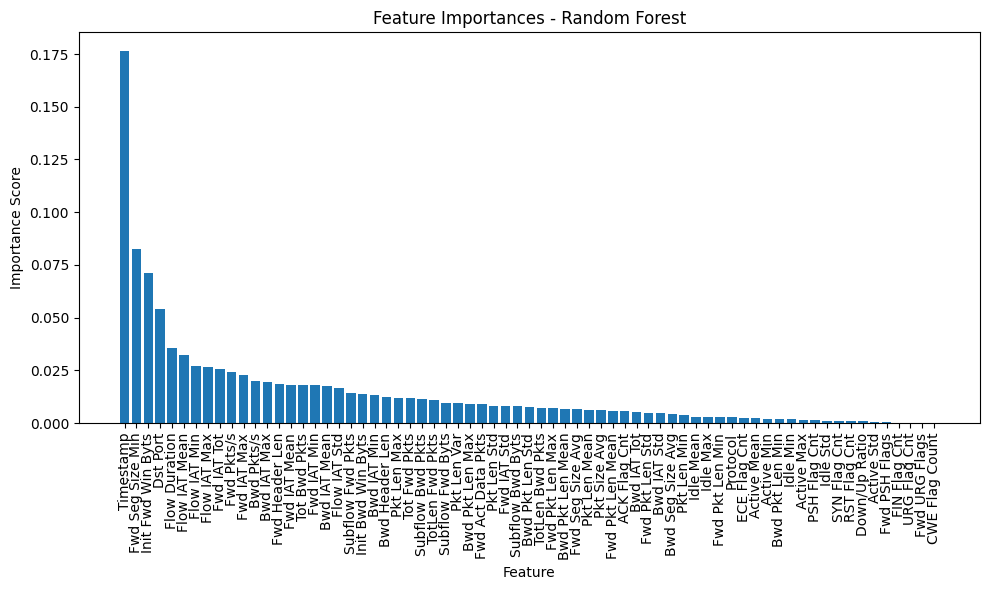

In [ ]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Get feature importances from the trained model
feature_importance = model.feature_importances_

# Create a DataFrame to associate each feature with its importance score
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})

# Sort the DataFrame in descending order of feature importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Optionally, plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Feature Importances - Random Forest')
plt.tight_layout()
plt.show()

In [ ]:
k = 15 # Number of top features to select
selected_features = feature_importance_df['Feature'][:k].values

# Select only the top k features from the training and testing sets
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

In [ ]:
df_cleaned_selected = df[selected_features].copy()

In [ ]:
df_cleaned_selected.shape

(203082, 15)

In [ ]:
X_train_selected.shape

(165963, 15)

In [ ]:
from collections import Counter

# Assuming you have already split your data into training and testing sets
# X_train and y_train are the feature matrix and target vector for the training set

# Count the occurrences of each class label in y_train
label_counts = Counter(y_train_oversampled)

print("Label Counts in y_train_oversampled:")
print(label_counts)

Label Counts in y_train_oversampled:
Counter({0: 79996, 3: 79996, 5: 79996, 7: 79996, 6: 79996, 4: 79996, 2: 79996, 8: 79996, 1: 79996})


In [ ]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_selected, y_train)

# Step 4: Train the LightGBM model
lgbm_model = LGBMClassifier(random_state=42)
lgbm_model.fit(X_train_selected, y_train)

# Step 5: Train the CatBoost model
catboost_model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=6, random_state=42)
catboost_model.fit(X_train_selected, y_train)

# Step 6: Make predictions on the testing data
y_pred_xgb = xgb_model.predict(X_test_selected)
y_pred_lgbm = lgbm_model.predict(X_test_selected)
y_pred_catboost = catboost_model.predict(X_test_selected)

# Step 7: Convert back the integer labels to original class labels
y_pred_xgb_original = label_encoder.inverse_transform(y_pred_xgb)
y_pred_lgbm_original = label_encoder.inverse_transform(y_pred_lgbm)
y_pred_catboost_original = label_encoder.inverse_transform(y_pred_catboost)

# Step 8: Evaluate the models
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catboost = accuracy_score(y_test, y_pred_catboost)

print("XGBoost Accuracy:", accuracy_xgb)
print("LightGBM Accuracy:", accuracy_lgbm)
print("CatBoost Accuracy:", accuracy_catboost)

# You can also print classification reports for more detailed evaluation
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))
print("LightGBM Classification Report:\n", classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_))
print("CatBoost Classification Report:\n", classification_report(y_test, y_pred_catboost, target_names=label_encoder.classes_))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3550
[LightGBM] [Info] Number of data points in the train set: 165963, number of used features: 15
[LightGBM] [Info] Start training from score -0.170544
[LightGBM] [Info] Start training from score -6.877857
[LightGBM] [Info] Start training from score -8.012187
[LightGBM] [Info] Start training from score -3.159589
[LightGBM] [Info] Start training from score -4.909641
[LightGBM] [Info] Start training from score -3.176482
[LightGBM] [Info] Start training from score -3.846791
[LightGBM] [Info] Start training from score -3.161152
[LightGBM] [Info] Start training from score -8.761424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


TypeError: ignored

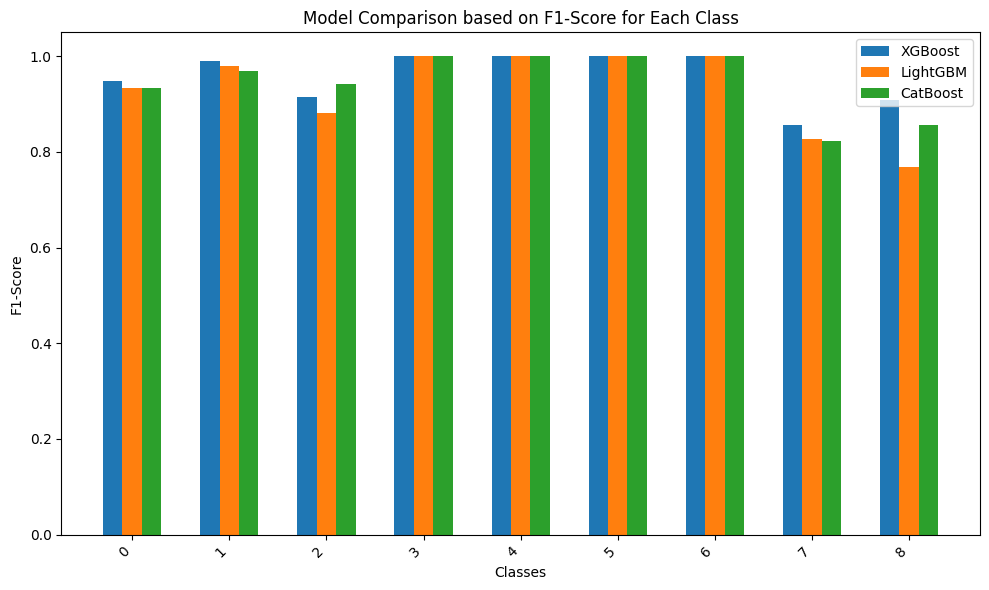

In [ ]:
from sklearn.metrics import classification_report, f1_score

# Assuming you have trained and obtained the predictions from XGBoost, LightGBM, and CatBoost
# and also have the corresponding true labels for each model (y_test)

# Compute F1-score for each class for each model
f1_scores_xgb = f1_score(y_test, y_pred_xgb, average=None)
f1_scores_lgbm = f1_score(y_test, y_pred_lgbm, average=None)
f1_scores_catboost = f1_score(y_test, y_pred_catboost, average=None)

# Get the unique class labels
class_labels = np.unique(y_test)

# Set the width of the bars
bar_width = 0.2

# Create positions for the bars
positions_xgb = np.arange(len(class_labels))
positions_lgbm = positions_xgb + bar_width
positions_catboost = positions_lgbm + bar_width

# Create a bar plot to compare the models for each class
plt.figure(figsize=(10, 6))

plt.bar(positions_xgb, f1_scores_xgb, width=bar_width, label='XGBoost')
plt.bar(positions_lgbm, f1_scores_lgbm, width=bar_width, label='LightGBM')
plt.bar(positions_catboost, f1_scores_catboost, width=bar_width, label='CatBoost')

plt.xticks(positions_lgbm, class_labels, rotation=45, ha='right')
plt.xlabel('Classes')
plt.ylabel('F1-Score')
plt.title('Model Comparison based on F1-Score for Each Class')
plt.legend()
plt.tight_layout()
plt.show()

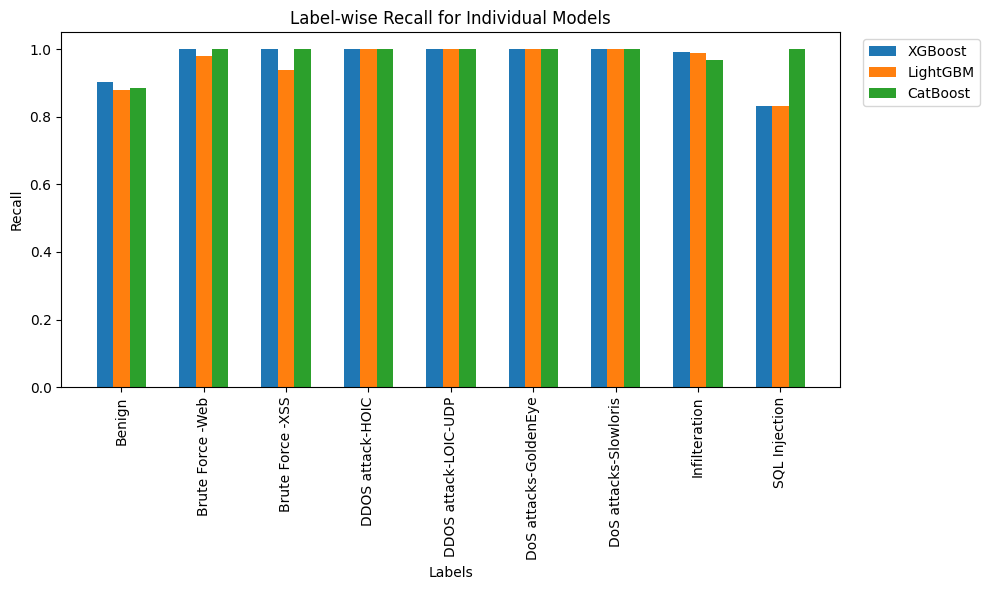

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Assuming you have obtained the predictions (y_pred_xgb, y_pred_lgbm, y_pred_catboost) and the true labels (y_test)

# Calculate recall for each model
recall_xgb = recall_score(y_test, y_pred_xgb, average=None)
recall_lgbm = recall_score(y_test, y_pred_lgbm, average=None)
recall_catboost = recall_score(y_test, y_pred_catboost, average=None)

# Get the labels for the x-axis
labels = label_encoder.classes_

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(r1, recall_xgb, width=bar_width, label='XGBoost')
plt.bar(r2, recall_lgbm, width=bar_width, label='LightGBM')
plt.bar(r3, recall_catboost, width=bar_width, label='CatBoost')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Label-wise Recall for Individual Models')
plt.xticks([r + bar_width for r in range(len(labels))], labels, rotation=90)

# Move the legend to the right side (outside the graph area)
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.ensemble import VotingClassifier

# Create the ensemble model using VotingClassifier
ensemble_model = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
        ('catboost', catboost_model)
    ],
    voting='soft'  # Use 'soft' voting for multiclass problems
)

# Fit the ensemble model on the training data (X_train_selected and y_train)
ensemble_model.fit(X_train_selected, y_train_oversampled)

# Make predictions using the ensemble model on the test data (X_test_selected)
y_pred_ensemble = ensemble_model.predict(X_test_selected)

# Calculate accuracy, precision, and F1-score for the combined model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
report_ensemble = classification_report(y_test, y_pred_ensemble)

# Print the results
print("Ensemble Model Accuracy:", accuracy_ensemble)
print("Ensemble Model Classification Report:\n", report_ensemble)

0:	learn: 1.6785427	total: 853ms	remaining: 14m 11s
1:	learn: 1.3878830	total: 1.71s	remaining: 14m 12s
2:	learn: 1.1852435	total: 2.52s	remaining: 13m 58s
3:	learn: 1.0342490	total: 3.46s	remaining: 14m 22s
4:	learn: 0.9098842	total: 4.87s	remaining: 16m 8s
5:	learn: 0.8125154	total: 6.47s	remaining: 17m 52s
6:	learn: 0.7353955	total: 8.16s	remaining: 19m 18s
7:	learn: 0.6638135	total: 9s	remaining: 18m 36s
8:	learn: 0.6049201	total: 9.87s	remaining: 18m 6s
9:	learn: 0.5535659	total: 10.7s	remaining: 17m 40s
10:	learn: 0.5088809	total: 11.6s	remaining: 17m 21s
11:	learn: 0.4662909	total: 12.4s	remaining: 17m 1s
12:	learn: 0.4305448	total: 13.2s	remaining: 16m 39s
13:	learn: 0.4001629	total: 14s	remaining: 16m 28s
14:	learn: 0.3731956	total: 14.8s	remaining: 16m 12s
15:	learn: 0.3477636	total: 15.7s	remaining: 16m 3s
16:	learn: 0.3262321	total: 16.5s	remaining: 15m 56s
17:	learn: 0.3103393	total: 17.2s	remaining: 15m 39s
18:	learn: 0.2912169	total: 18.1s	remaining: 15m 33s
19:	learn: 0

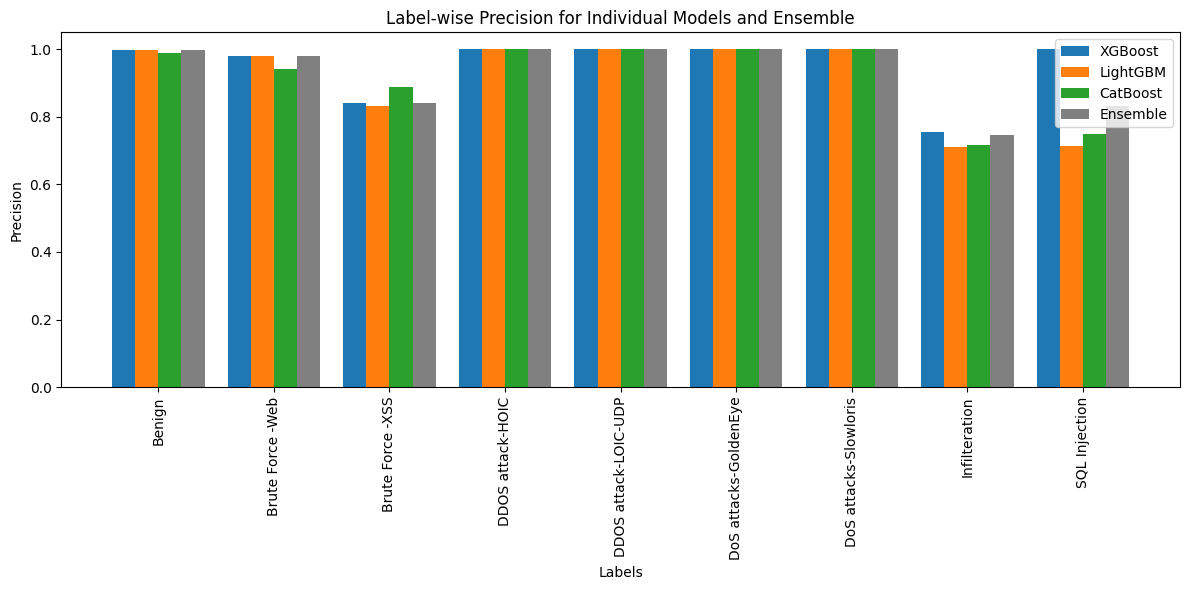

In [ ]:
report_xgb = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_, output_dict=True)
report_lgbm = classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_, output_dict=True)
report_catboost = classification_report(y_test, y_pred_catboost, target_names=label_encoder.classes_, output_dict=True)

# Assuming you have obtained the predictions for the ensemble model (y_pred_ensemble)
report_ensemble = classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_, output_dict=True)

# Extract precision, recall, and F1-score for each label from each report
labels = label_encoder.classes_
precision_xgb = [report_xgb[label]['precision'] for label in labels]
recall_xgb = [report_xgb[label]['recall'] for label in labels]
f1score_xgb = [report_xgb[label]['f1-score'] for label in labels]

precision_lgbm = [report_lgbm[label]['precision'] for label in labels]
recall_lgbm = [report_lgbm[label]['recall'] for label in labels]
f1score_lgbm = [report_lgbm[label]['f1-score'] for label in labels]

precision_catboost = [report_catboost[label]['precision'] for label in labels]
recall_catboost = [report_catboost[label]['recall'] for label in labels]
f1score_catboost = [report_catboost[label]['f1-score'] for label in labels]

precision_ensemble = [report_ensemble[label]['precision'] for label in labels]
recall_ensemble = [report_ensemble[label]['recall'] for label in labels]
f1score_ensemble = [report_ensemble[label]['f1-score'] for label in labels]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar plot
plt.figure(figsize=(12, 6))  # Adjust the figure size
plt.bar(r1, precision_xgb, width=bar_width, label='XGBoost')
plt.bar(r2, precision_lgbm, width=bar_width, label='LightGBM')
plt.bar(r3, precision_catboost, width=bar_width, label='CatBoost')
plt.bar(r4, precision_ensemble, width=bar_width, label='Ensemble', color='gray')

# Add labels and legend
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.title('Label-wise Precision for Individual Models and Ensemble')
plt.xticks([r + bar_width * 1.5 for r in range(len(labels))], labels, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


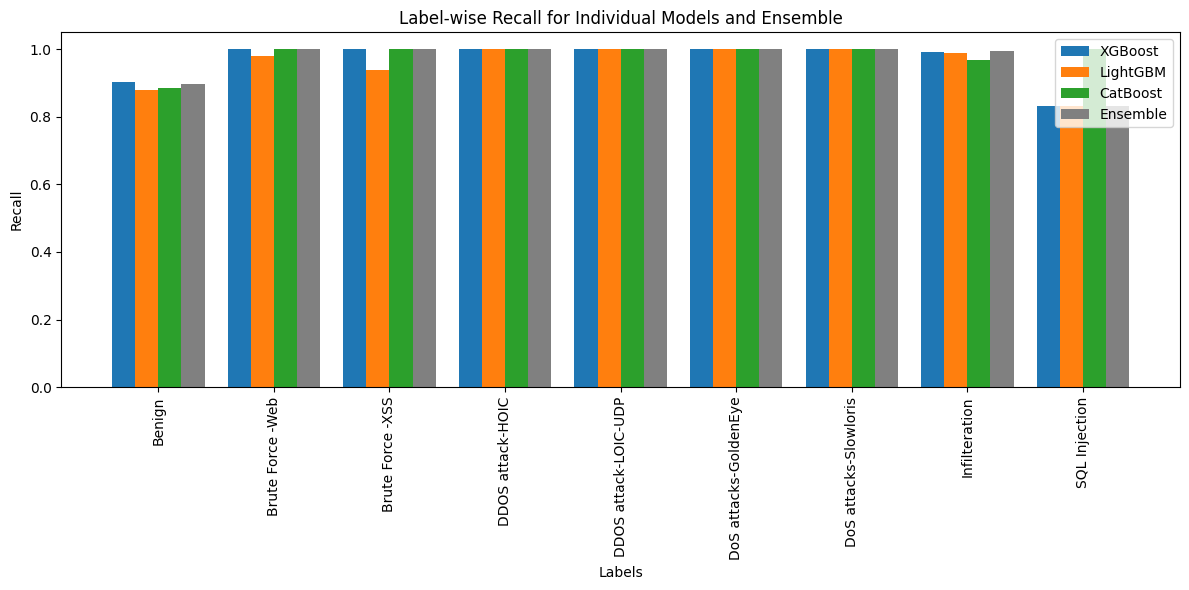

In [ ]:

from sklearn.metrics import recall_score

# Assuming you have obtained the predictions (y_pred_xgb, y_pred_lgbm, y_pred_catboost, y_pred_ensemble) and the true labels (y_test)

# Calculate recall for each model
recall_xgb = recall_score(y_test, y_pred_xgb, average=None)
recall_lgbm = recall_score(y_test, y_pred_lgbm, average=None)
recall_catboost = recall_score(y_test, y_pred_catboost, average=None)
recall_ensemble = recall_score(y_test, y_pred_ensemble, average=None)

# Get the labels for the x-axis
labels = label_encoder.classes_

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, recall_xgb, width=bar_width, label='XGBoost')
plt.bar(r2, recall_lgbm, width=bar_width, label='LightGBM')
plt.bar(r3, recall_catboost, width=bar_width, label='CatBoost')
plt.bar(r4, recall_ensemble, width=bar_width, label='Ensemble', color='gray')

# Add labels and legend
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Label-wise Recall for Individual Models and Ensemble')
plt.xticks([r + bar_width * 1.5 for r in range(len(labels))], labels, rotation=90)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


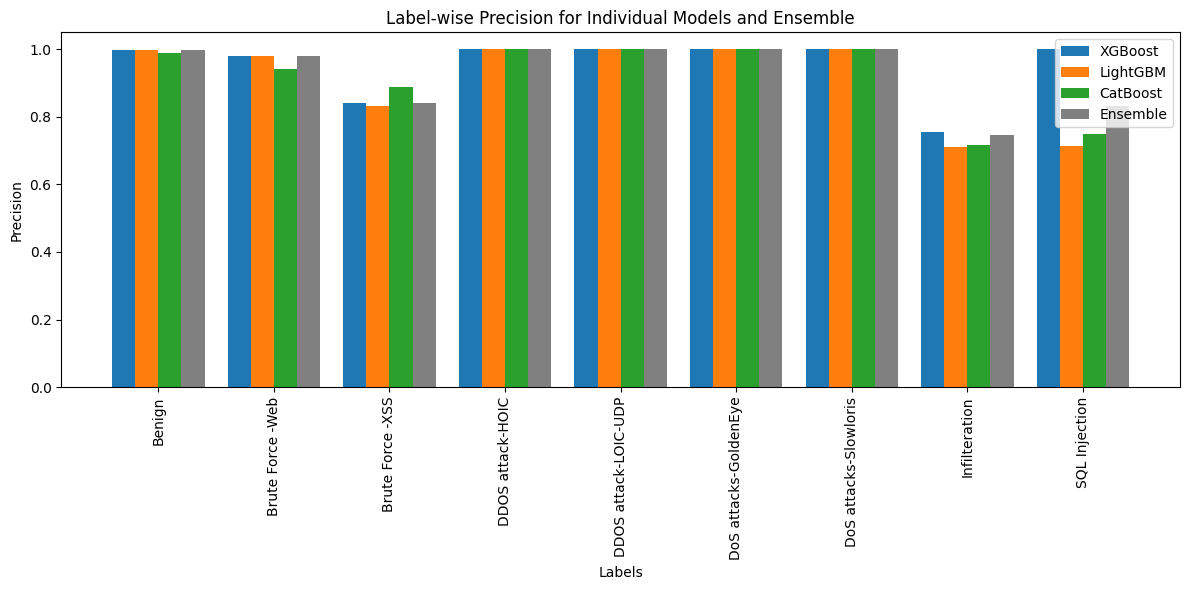

In [ ]:


# Assuming you have obtained the predictions (y_pred_xgb, y_pred_lgbm, y_pred_catboost) and the true labels (y_test)

# Calculate classification reports for each model
report_xgb = classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_, output_dict=True)
report_lgbm = classification_report(y_test, y_pred_lgbm, target_names=label_encoder.classes_, output_dict=True)
report_catboost = classification_report(y_test, y_pred_catboost, target_names=label_encoder.classes_, output_dict=True)

# Assuming you have obtained the predictions for the ensemble model (y_pred_ensemble)
report_ensemble = classification_report(y_test, y_pred_ensemble, target_names=label_encoder.classes_, output_dict=True)

# Extract precision, recall, and F1-score for each label from each report
labels = label_encoder.classes_
precision_xgb = [report_xgb[label]['precision'] for label in labels]
recall_xgb = [report_xgb[label]['recall'] for label in labels]
f1score_xgb = [report_xgb[label]['f1-score'] for label in labels]

precision_lgbm = [report_lgbm[label]['precision'] for label in labels]
recall_lgbm = [report_lgbm[label]['recall'] for label in labels]
f1score_lgbm = [report_lgbm[label]['f1-score'] for label in labels]

precision_catboost = [report_catboost[label]['precision'] for label in labels]
recall_catboost = [report_catboost[label]['recall'] for label in labels]
f1score_catboost = [report_catboost[label]['f1-score'] for label in labels]

precision_ensemble = [report_ensemble[label]['precision'] for label in labels]
recall_ensemble = [report_ensemble[label]['recall'] for label in labels]
f1score_ensemble = [report_ensemble[label]['f1-score'] for label in labels]

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, precision_xgb, width=bar_width, label='XGBoost')
plt.bar(r2, precision_lgbm, width=bar_width, label='LightGBM')
plt.bar(r3, precision_catboost, width=bar_width, label='CatBoost')
plt.bar(r4, precision_ensemble, width=bar_width, label='Ensemble', color='gray')

# Add labels and legend
plt.xlabel('Labels')
plt.ylabel('Precision')
plt.title('Label-wise Precision for Individual Models and Ensemble')
plt.xticks([r + bar_width * 1.5 for r in range(len(labels))], labels, rotation=90)
plt.legend()

# Adjust margins and layout
plt.tight_layout()

# Show the plot
plt.show()


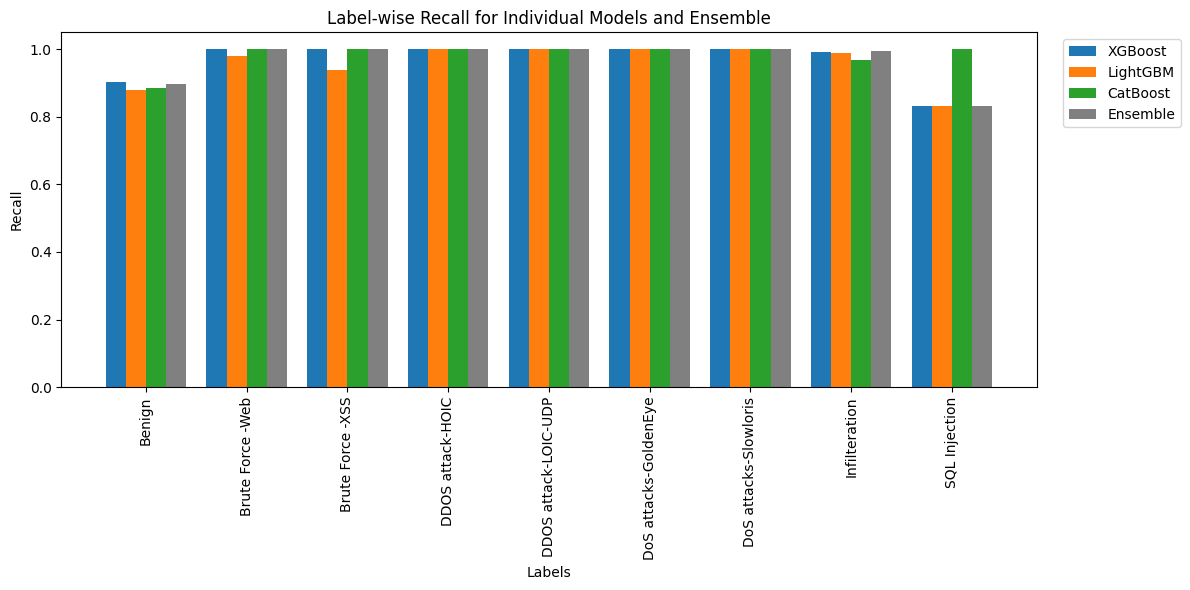

In [ ]:


# Assuming you have obtained the predictions (y_pred_xgb, y_pred_lgbm, y_pred_catboost, y_pred_ensemble) and the true labels (y_test)

# Calculate recall for each model
recall_xgb = recall_score(y_test, y_pred_xgb, average=None)
recall_lgbm = recall_score(y_test, y_pred_lgbm, average=None)
recall_catboost = recall_score(y_test, y_pred_catboost, average=None)
recall_ensemble = recall_score(y_test, y_pred_ensemble, average=None)

# Get the labels for the x-axis
labels = label_encoder.classes_

# Set the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(labels))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the bar plot
plt.figure(figsize=(12, 6))
plt.bar(r1, recall_xgb, width=bar_width, label='XGBoost')
plt.bar(r2, recall_lgbm, width=bar_width, label='LightGBM')
plt.bar(r3, recall_catboost, width=bar_width, label='CatBoost')
plt.bar(r4, recall_ensemble, width=bar_width, label='Ensemble', color='gray')

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Recall')
plt.title('Label-wise Recall for Individual Models and Ensemble')
plt.xticks([r + bar_width * 1.5 for r in range(len(labels))], labels, rotation=90)

# Move the legend outside the graph area
plt.legend(loc='upper left', bbox_to_anchor=(1.02, 1))
# Show the plot
plt.tight_layout()
plt.show()
